# Question 2 


In [1]:
import numpy as np
import tensorflow as tf
import pickle 

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#Load the data
with open('/content/gdrive/MyDrive/time_series_1.pickle', 'rb') as f:
    time_series_1 = np.array(pickle.load(f))

In [4]:
with open('/content/gdrive/MyDrive/time_series_2.pickle', 'rb') as f:
    time_series_2 = np.array(pickle.load(f))

In [5]:
with open('/content/gdrive/MyDrive/y.pickle', 'rb') as f:
    y = np.array(pickle.load(f))

In [6]:
# Create a TensorFlow dataset from the data
dataset = tf.data.Dataset.from_tensor_slices((time_series_1, time_series_2, y))


In [7]:
# Define batch size and buffer size for shuffling
batch_size = 32
buffer_size = 10000

In [8]:
# Shuffle and batch the data
dataset = dataset.shuffle(buffer_size=buffer_size)
dataset = dataset.batch(batch_size=batch_size)


In [9]:
def preprocess_data(x1, x2, y):
    def np_preprocess(x1_np, x2_np, y_np):
        x = np.stack((x1_np, x2_np), axis=-1)  # stack the time series data along the feature axis
        y = tf.keras.utils.to_categorical(y_np, num_classes=3)  # one-hot encode the labels
        return x, y
    
    x1 = tf.cast(x1, tf.float32)
    x2 = tf.cast(x2, tf.float32)
    
    x, y = tf.numpy_function(np_preprocess, [x1, x2, y], [tf.float32, tf.float32])
    return x, y

In [10]:
# Map the preprocessing function to the dataset
dataset = dataset.map(preprocess_data)


In [11]:
# Prefetch the dataset for performance
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Question 3

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, SimpleRNN, GRU, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [19]:
X = np.concatenate((time_series_1, time_series_2), axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.80      0.78      0.79       208
         1.0       0.99      0.99      0.99       184
         2.0       0.99      0.98      0.98       203
         3.0       0.78      0.80      0.79       205

    accuracy                           0.89       800
   macro avg       0.89      0.89      0.89       800
weighted avg       0.89      0.89      0.89       800



In [23]:
X_train_3d = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_3d = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [24]:
# Reshape input data
X_train_3d = X_train.reshape(X_train.shape[0], X_train.shape[1]//2, 2)
X_test_3d = X_test.reshape(X_test.shape[0], X_test.shape[1]//2, 2)


In [25]:
# Build the model
model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape=(5000, 2)))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [26]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [27]:
# Train the model
history = model.fit(X_train_3d, y_train, epochs=10, validation_data=(X_test_3d, y_test))

Epoch 1/10
100/100 [==============================] - 63s 613ms/step - loss: -108603.5703 - accuracy: 0.2550 - val_loss: -580833.0625 - val_accuracy: 0.2300
Epoch 2/10
100/100 [==============================] - 47s 467ms/step - loss: -4359478.5000 - accuracy: 0.2550 - val_loss: -12797585.0000 - val_accuracy: 0.2300
Epoch 3/10
100/100 [==============================] - 47s 473ms/step - loss: -36578820.0000 - accuracy: 0.2550 - val_loss: -76252168.0000 - val_accuracy: 0.2300
Epoch 4/10
100/100 [==============================] - 48s 474ms/step - loss: -151851024.0000 - accuracy: 0.2550 - val_loss: -262134048.0000 - val_accuracy: 0.2300
Epoch 5/10
100/100 [==============================] - 45s 448ms/step - loss: -434969472.0000 - accuracy: 0.2550 - val_loss: -673494336.0000 - val_accuracy: 0.2300
Epoch 6/10
100/100 [==============================] - 46s 458ms/step - loss: -1008654272.0000 - accuracy: 0.2550 - val_loss: -1454248320.0000 - val_accuracy: 0.2300
Epoch 7/10
100/100 [===========

In [28]:
loss, accuracy = model.evaluate(X_test_3d, y_test)
print(f'Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}')


25/25 [==============================] - 3s 134ms/step - loss: -11107670016.0000 - accuracy: 0.2300
Test loss: -11107670016.000, Test accuracy: 0.230


In [29]:
y_pred = model.predict(X_test_3d[:10])
print(y_pred)


1/1 [==============================] - 0s 471ms/step
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


# Question 6


In [30]:
import numpy as np
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [31]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [32]:
with open('/content/gdrive/MyDrive/time_series_1.pickle', 'rb') as f:
    time_series_1 = np.array(pickle.load(f))

In [33]:
with open('/content/gdrive/MyDrive/time_series_2.pickle', 'rb') as f:
    time_series_2 = np.array(pickle.load(f))

In [34]:
with open('/content/gdrive/MyDrive/y.pickle', 'rb') as f:
    y = np.array(pickle.load(f))

In [35]:
# Convert to grayscale images
def convert_to_grayscale(ts1, ts2):
    img = np.zeros((100, 100, 1))
    for i in range(100):
        for j in range(100):
            img[i, j, 0] = (ts1[i] + ts2[j]) / 2
    return img

X = []
for i in range(len(time_series_1)):
    X.append(convert_to_grayscale(time_series_1[i], time_series_2[i]))
X = np.array(X)

In [36]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [37]:
# Define model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100,100,1)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [38]:
# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [41]:
# Train model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
100/100 [==============================] - 62s 618ms/step - loss: -129647446589440.0000 - accuracy: 0.2550 - val_loss: -164047081177088.0000 - val_accuracy: 0.2300
Epoch 2/10
100/100 [==============================] - 66s 658ms/step - loss: -200294625443840.0000 - accuracy: 0.2550 - val_loss: -248317879517184.0000 - val_accuracy: 0.2300
Epoch 3/10
100/100 [==============================] - 63s 628ms/step - loss: -297096343191552.0000 - accuracy: 0.2550 - val_loss: -361216983695360.0000 - val_accuracy: 0.2300
Epoch 4/10
100/100 [==============================] - 61s 611ms/step - loss: -426598733971456.0000 - accuracy: 0.2550 - val_loss: -512660349124608.0000 - val_accuracy: 0.2300
Epoch 5/10
100/100 [==============================] - 63s 632ms/step - loss: -594360190107648.0000 - accuracy: 0.2550 - val_loss: -703023332458496.0000 - val_accuracy: 0.2300
Epoch 6/10
100/100 [==============================] - 62s 615ms/step - loss: -805525948203008.0000 - accuracy: 0.2550 - val_l

In [40]:
# Evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

25/25 [==============================] - 8s 338ms/step - loss: -103932571418624.0000 - accuracy: 0.2300
Test accuracy: 0.23000000417232513


In [43]:
import matplotlib.pyplot as plt


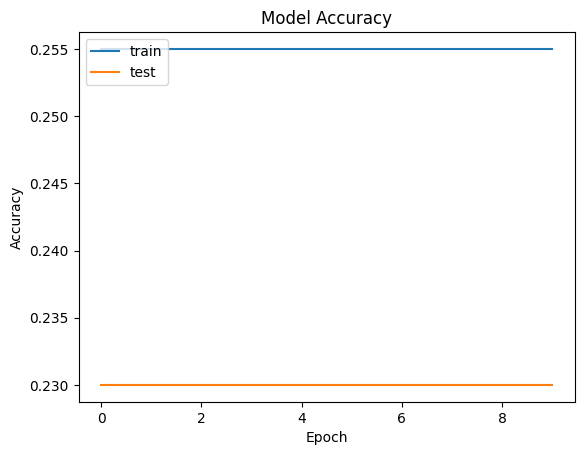

In [44]:
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

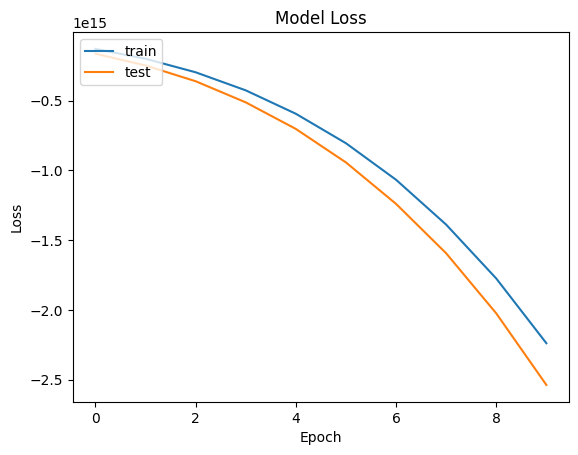

In [45]:
# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Question 8

In [60]:
images = []
for i in range(len(time_series_1)):
    ts1 = time_series_1[i]
    ts2 = time_series_2[i]
    combined = np.vstack((ts1, ts2)).T
    combined = np.expand_dims(combined, axis=-1)  # Add an extra dimension for channels
    if combined.shape[0] >= 256 and combined.shape[1] >= 256:
        image = tf.image.resize_with_pad(combined, target_height=256, target_width=256)
    else:
        image = combined
    images.append(image)

X = np.stack(images)
y = np.array(y)

In [61]:
# Split the data into training and validation sets
indices = np.random.permutation(len(X))
train_indices = indices[:int(0.8*len(X))]
val_indices = indices[int(0.8*len(X)):]

In [62]:
X_train = X[train_indices]
y_train = y[train_indices]
X_val = X[val_indices]
y_val = y[val_indices]

In [63]:
 #Define the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(100, 100, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [64]:
# Define the model architecture
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(100,100,1)),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(1, activation='sigmoid')
])


In [65]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [66]:
# Reshape the training data
X_train = X_train.reshape(-1, 100, 100, 1)

# Reshape the validation data
X_val = X_val.reshape(-1, 100, 100, 1)


In [67]:
# Train the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)


Epoch 1/10
100/100 [==============================] - 26s 247ms/step - loss: -164715.8438 - accuracy: 0.2503 - val_loss: -505342.7188 - val_accuracy: 0.2488
Epoch 2/10
100/100 [==============================] - 27s 273ms/step - loss: -1581228.0000 - accuracy: 0.2503 - val_loss: -2600758.5000 - val_accuracy: 0.2488
Epoch 3/10
100/100 [==============================] - 19s 190ms/step - loss: -4875563.0000 - accuracy: 0.2503 - val_loss: -6283508.0000 - val_accuracy: 0.2488
Epoch 4/10
100/100 [==============================] - 19s 187ms/step - loss: -9896020.0000 - accuracy: 0.2503 - val_loss: -11485496.0000 - val_accuracy: 0.2488
Epoch 5/10
100/100 [==============================] - 19s 189ms/step - loss: -16596835.0000 - accuracy: 0.2503 - val_loss: -18167942.0000 - val_accuracy: 0.2488
Epoch 6/10
100/100 [==============================] - 20s 203ms/step - loss: -24990620.0000 - accuracy: 0.2503 - val_loss: -26331298.0000 - val_accuracy: 0.2488
Epoch 7/10
100/100 [=======================

In [68]:
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(X_val, y_val)
print('Validation accuracy:', val_acc)

25/25 [==============================] - 3s 105ms/step - loss: -71747768.0000 - accuracy: 0.2488
Validation accuracy: 0.2487500011920929


# Question 9 


In [88]:
import tensorflow as tf
import numpy as np
import pickle
from tensorflow import keras
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, concatenate
from keras.models import Model


In [70]:
# Split the data into training, validation, and test sets
train_val_split = int(0.8 * len(time_series_1))
time_series_1_train_val = time_series_1[:train_val_split]
time_series_2_train_val = time_series_2[:train_val_split]
y_train_val = y[:train_val_split]


In [71]:
time_series_1_test = time_series_1[train_val_split:]
time_series_2_test = time_series_2[train_val_split:]
y_test = y[train_val_split:]


In [72]:
train_split = int(0.8 * len(time_series_1_train_val))
time_series_1_train = time_series_1_train_val[:train_split]
time_series_2_train = time_series_2_train_val[:train_split]
y_train = y_train_val[:train_split]

time_series_1_val = time_series_1_train_val[train_split:]
time_series_2_val = time_series_2_train_val[train_split:]
y_val = y_train_val[train_split:]

In [73]:
# Define the input layers
input1 = Input(shape=(5000, 1))
input2 = Input(shape=(5000, 1))

In [75]:
# Define the first model
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(5000, 2)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [76]:
# Define the convolutional layers for the first input
conv1_1 = Conv1D(filters=32, kernel_size=3, activation='relu')(input1)
pool1_1 = MaxPooling1D(pool_size=2)(conv1_1)
conv2_1 = Conv1D(filters=64, kernel_size=3, activation='relu')(pool1_1)
pool2_1 = MaxPooling1D(pool_size=2)(conv2_1)
conv3_1 = Conv1D(filters=128, kernel_size=3, activation='relu')(pool2_1)
pool3_1 = MaxPooling1D(pool_size=2)(conv3_1)
flat1 = Flatten()(pool3_1)

In [77]:
# Define the convolutional layers for the second input
conv1_2 = Conv1D(filters=32, kernel_size=3, activation='relu')(input2)
pool1_2 = MaxPooling1D(pool_size=2)(conv1_2)
conv2_2 = Conv1D(filters=64, kernel_size=3, activation='relu')(pool1_2)
pool2_2 = MaxPooling1D(pool_size=2)(conv2_2)
conv3_2 = Conv1D(filters=128, kernel_size=3, activation='relu')(pool2_2)
pool3_2 = MaxPooling1D(pool_size=2)(conv3_2)
flat2 = Flatten()(pool3_2)

In [78]:
#Concatenate the two flattened layers
merged = concatenate([flat1, flat2])

# Define the output layer
output = Dense(units=1, activation='sigmoid')(merged)

In [79]:
# Define the model
model1 = Model(inputs=[input1, input2], outputs=output)

In [80]:
# Compile the first model
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [83]:
# Train the first model
history1 = model1.fit([time_series_1_train, time_series_2_train], y_train, validation_data=([time_series_1_val, time_series_2_val], y_val), epochs=10, batch_size=32)


Epoch 1/10
80/80 [==============================] - 80s 998ms/step - loss: -3060504199168.0000 - accuracy: 0.2531 - val_loss: -3363358638080.0000 - val_accuracy: 0.2531
Epoch 2/10
80/80 [==============================] - 78s 972ms/step - loss: -4327248756736.0000 - accuracy: 0.2531 - val_loss: -4675272179712.0000 - val_accuracy: 0.2531
Epoch 3/10
80/80 [==============================] - 86s 1s/step - loss: -5917338763264.0000 - accuracy: 0.2531 - val_loss: -6294411411456.0000 - val_accuracy: 0.2531
Epoch 4/10
80/80 [==============================] - 78s 984ms/step - loss: -7886387806208.0000 - accuracy: 0.2531 - val_loss: -8328881111040.0000 - val_accuracy: 0.2531
Epoch 5/10
80/80 [==============================] - 81s 1s/step - loss: -10281806725120.0000 - accuracy: 0.2531 - val_loss: -10789660393472.0000 - val_accuracy: 0.2531
Epoch 6/10
80/80 [==============================] - 82s 1s/step - loss: -13164233097216.0000 - accuracy: 0.2531 - val_loss: -13654550380544.0000 - val_accuracy

In [84]:
# Evaluate the first model on the test set
test_loss1, test_acc1 = model1.evaluate([time_series_1_test, time_series_2_test], y_test)
print('Test accuracy for model 1:', test_acc1)


25/25 [==============================] - 9s 350ms/step - loss: -34155536580608.0000 - accuracy: 0.2375
Test accuracy for model 1: 0.23749999701976776


In [85]:
# Define the second model
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

58889256/58889256 [==============================] - 2s 0us/step


In [86]:
inputs = tf.keras.layers.Input(shape=(5000, 2, 1))
x = tf.keras.layers.Lambda(lambda x: tf.keras.backend.repeat_elements(x, 3, 2))(inputs)
x = tf.keras.layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x))(x)
x = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, (224, 224)))(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)

model2 = tf.keras.models.Model(inputs=inputs, outputs=outputs)


In [89]:
# Define the input layers
input1 = keras.layers.Input(shape=(5000,))
input2 = keras.layers.Input(shape=(5000,))

In [90]:
# Concatenate the inputs
concat = keras.layers.concatenate([input1, input2])

# Add the layers for the model
x = keras.layers.Dense(32, activation='relu')(concat)
x = keras.layers.Dense(16, activation='relu')(x)
output = keras.layers.Dense(1, activation='sigmoid')(x)


In [91]:
 #Create the model
model2 = keras.models.Model(inputs=[input1, input2], outputs=output)


In [92]:
# Compile the second model
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [93]:
# Train the second model
history2 = model2.fit([time_series_1_train, time_series_2_train], y_train, validation_data=([time_series_1_val, time_series_2_val], y_val), epochs=10, batch_size=32)

Epoch 1/10
80/80 [==============================] - 3s 19ms/step - loss: -58174.0117 - accuracy: 0.2555 - val_loss: -163389.4531 - val_accuracy: 0.2531
Epoch 2/10
80/80 [==============================] - 2s 21ms/step - loss: -534049.6875 - accuracy: 0.2531 - val_loss: -981179.8125 - val_accuracy: 0.2531
Epoch 3/10
80/80 [==============================] - 3s 38ms/step - loss: -2092154.0000 - accuracy: 0.2531 - val_loss: -3191019.5000 - val_accuracy: 0.2531
Epoch 4/10
80/80 [==============================] - 1s 14ms/step - loss: -5551447.0000 - accuracy: 0.2531 - val_loss: -7515494.5000 - val_accuracy: 0.2531
Epoch 5/10
80/80 [==============================] - 1s 14ms/step - loss: -11761064.0000 - accuracy: 0.2531 - val_loss: -14683048.0000 - val_accuracy: 0.2531
Epoch 6/10
80/80 [==============================] - 1s 10ms/step - loss: -21304010.0000 - accuracy: 0.2531 - val_loss: -25315496.0000 - val_accuracy: 0.2531
Epoch 7/10
80/80 [==============================] - 1s 10ms/step - loss

In [94]:
# Evaluate the first model on the test set
test_loss2, test_acc2 = model2.evaluate([time_series_1_test, time_series_2_test], y_test)
print('Test accuracy for model 2:', test_acc1)


25/25 [==============================] - 0s 8ms/step - loss: -125701024.0000 - accuracy: 0.2375
Test accuracy for model 2: 0.23749999701976776


In [95]:
#compare the models
if test_acc1 >= test_acc2:
    best_model = model1
else:
    best_model = model2


In [96]:
history_best = best_model.fit([np.concatenate((time_series_1_train, time_series_1_val)), np.concatenate((time_series_2_train, time_series_2_val))], np.concatenate((y_train, y_val)), epochs=10, batch_size=32)


Epoch 1/10
100/100 [==============================] - 96s 955ms/step - loss: -36414188158976.0000 - accuracy: 0.2531
Epoch 2/10
100/100 [==============================] - 91s 911ms/step - loss: -44712215969792.0000 - accuracy: 0.2531
Epoch 3/10
100/100 [==============================] - 90s 905ms/step - loss: -54269696802816.0000 - accuracy: 0.2531
Epoch 4/10
100/100 [==============================] - 91s 916ms/step - loss: -65145099255808.0000 - accuracy: 0.2531
Epoch 5/10
100/100 [==============================] - 91s 907ms/step - loss: -77381519802368.0000 - accuracy: 0.2531
Epoch 6/10
100/100 [==============================] - 90s 902ms/step - loss: -91160311758848.0000 - accuracy: 0.2531
Epoch 7/10
100/100 [==============================] - 89s 894ms/step - loss: -106372028956672.0000 - accuracy: 0.2531
Epoch 8/10
100/100 [==============================] - 90s 904ms/step - loss: -123293436739584.0000 - accuracy: 0.2531
Epoch 9/10
100/100 [==============================] - 89s 896m

In [97]:
test_loss_best, test_acc_best = best_model.evaluate([time_series_1_test, time_series_2_test], y_test)
print('Test accuracy for the best model:', test_acc_best)

25/25 [==============================] - 10s 372ms/step - loss: -181585714348032.0000 - accuracy: 0.2375
Test accuracy for the best model: 0.23749999701976776
